In [1]:
# !pip install "cloudpathlib[azure]" loguru tqdm typer
# !pip install xarray xarray-spatial

In [1]:
%reload_ext autoreload
%autoreload 2

# import sys
# sys.path.insert(0, '../')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import pandas as pd
pd.set_option("display.max_colwidth", 250)
import matplotlib.pyplot as plt
import rasterio
import glob
import numpy as np
import pyproj
import shutil
import bcolz
import xarray
import cv2
import xrspatial.multispectral as ms
from PIL import Image
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
cpus = multiprocessing.cpu_count()
cpus = min(32, cpus)
print(f"{cpus} cpus")

from src.train import train
from src.hyperparams import HyperParams, open_from_yaml
from src.dataloader import *
from src.datasets import LoadTifDataset
from src.validate import *

32 cpus


# Explore

In [5]:
train_meta = pd.read_csv("data/train_metadata.csv")
train_meta.head()

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj


In [6]:
# how many different chip ids, locations, and datetimes are there?
train_meta[["chip_id", "location", "datetime"]].nunique()

chip_id     11748
location       81
datetime       91
dtype: int64

In [7]:
train_meta["location"].value_counts()

Chifunfu      341
Timbuktu      321
Chingola      321
Lusaka        309
Bambesa       267
             ... 
Sudan           9
Gabon           9
Sfax            6
Morocco         4
Angkor Wat      2
Name: location, Length: 81, dtype: int64

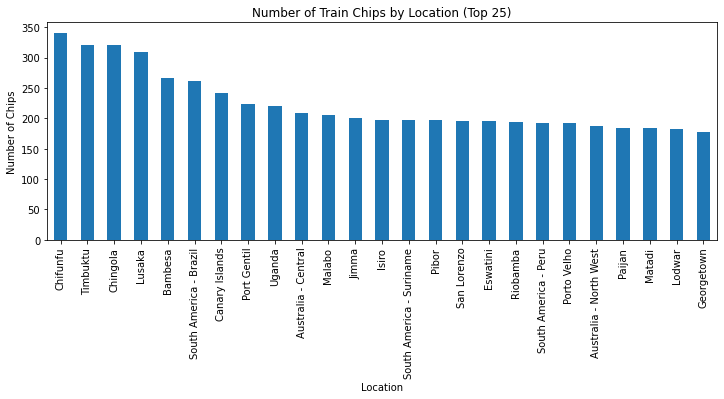

In [8]:
train_location_counts = (
    train_meta.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)
plt.figure(figsize=(12, 4))
train_location_counts.head(25).plot(kind="bar")
plt.xticks(rotation=90)
plt.xlabel("Location")
plt.ylabel("Number of Chips")
plt.title("Number of Train Chips by Location (Top 25)")
plt.show()

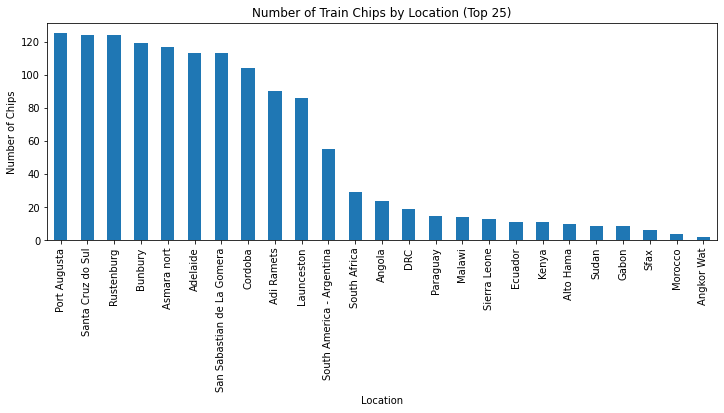

In [9]:
train_location_counts = (
    train_meta.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)
plt.figure(figsize=(12, 4))
train_location_counts.tail(25).plot(kind="bar")
plt.xticks(rotation=90)
plt.xlabel("Location")
plt.ylabel("Number of Chips")
plt.title("Number of Train Chips by Location (Top 25)")
plt.show()

In [10]:
train_meta["datetime"] = pd.to_datetime(train_meta["datetime"])
train_meta["year"] = train_meta.datetime.dt.year
train_meta.groupby("year")[["chip_id"]].nunique().sort_index().rename(
    columns={"chip_id": "chip_count"}
)

,chip_count
year,
2018,326
2019,1015
2020,10407


In [11]:
train_meta["datetime"].min(), train_meta["datetime"].max()

(Timestamp('2018-03-07 08:46:02+0000', tz='UTC'),
 Timestamp('2020-09-14 08:28:49+0000', tz='UTC'))

In [12]:
chips_per_locationtime = (
    train_meta.groupby(["location", "datetime"])[["chip_id"]]
    .nunique()
    .sort_values(by="chip_id", ascending=False)
    .rename(columns={"chip_id": "chip_count"})
)
chips_per_locationtime.head(10)

,,chip_count
location,datetime,
South America - Brazil,2020-09-06 15:02:37+00:00,261
Port Gentil,2020-09-08 09:50:58+00:00,223
Uganda,2019-04-25 08:29:37+00:00,220
Australia - Central,2020-08-11 01:24:00+00:00,209
Malabo,2020-09-06 10:00:03+00:00,206
Jimma,2020-05-31 08:07:58+00:00,201
Chifunfu,2020-04-29 08:20:47+00:00,197
South America - Suriname,2020-06-03 14:11:18+00:00,197
Isiro,2020-08-28 08:39:29+00:00,197


In [13]:
BANDS = ["B02", "B03", "B04", "B08"]

def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column
    added indicating the path to each band's TIF image as "{band}_path", eg "B02_path".
    A column is also added to the dataframe with paths to the label TIF, if the
    path to the labels directory is provided.
    """
    for band in bands:
        df[f"{band}_path"] = df["chip_id"].apply(lambda x: f"{feature_dir}/{x}/{band}.tif")
#         assert df[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = df["chip_id"].apply(lambda x: f"{label_dir}/{x}.tif")
#         assert df["label_path"].path.exists().all()

    return df


train_meta = add_paths(train_meta, "data/train_features", "data/train_labels")
train_meta.head()

,chip_id,location,datetime,cloudpath,year,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwp,2020,data/train_features/adwp/B02.tif,data/train_features/adwp/B03.tif,data/train_features/adwp/B04.tif,data/train_features/adwp/B08.tif,data/train_labels/adwp.tif
1,adwu,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwu,2020,data/train_features/adwu/B02.tif,data/train_features/adwu/B03.tif,data/train_features/adwu/B04.tif,data/train_features/adwu/B08.tif,data/train_labels/adwu.tif
2,adwz,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwz,2020,data/train_features/adwz/B02.tif,data/train_features/adwz/B03.tif,data/train_features/adwz/B04.tif,data/train_features/adwz/B08.tif,data/train_labels/adwz.tif
3,adxp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adxp,2020,data/train_features/adxp/B02.tif,data/train_features/adxp/B03.tif,data/train_features/adxp/B04.tif,data/train_features/adxp/B08.tif,data/train_labels/adxp.tif
4,aeaj,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/aeaj,2020,data/train_features/aeaj/B02.tif,data/train_features/aeaj/B03.tif,data/train_features/aeaj/B04.tif,data/train_features/aeaj/B08.tif,data/train_labels/aeaj.tif


In [14]:
len(glob.glob("data/train_features/*")), len(glob.glob("data/train_features/*/*"))

(11748, 46992)

In [15]:
len(glob.glob("data/train_labels/*"))

12798

In [16]:
example_chip = train_meta.sample(1)

In [17]:
example_chip = example_chip.iloc[0]
with rasterio.open(example_chip["B04_path"]) as img:
    chip_metadata = img.meta
    img_array = img.read(1)

chip_metadata

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32722),
 'transform': Affine(10.0, 0.0, 340740.0,
        0.0, -10.0, 6742130.0)}

In [18]:
# what does the image array look like?
print("Image array shape:", img_array.shape)
img_array

Image array shape: (512, 512)


array([[3724, 3532, 3216, ..., 1148, 1102, 1032],
       [3630, 3362, 2928, ..., 1322, 1164, 1062],
       [3496, 3000, 2702, ..., 1460, 1278, 1138],
       ...,
       [5092, 5748, 5956, ..., 1198, 1226, 1224],
       [4912, 5724, 5988, ..., 1212, 1226, 1208],
       [4792, 5556, 5816, ..., 1176, 1216, 1246]], dtype=uint16)

In [19]:
np.isnan(img_array).sum()

0

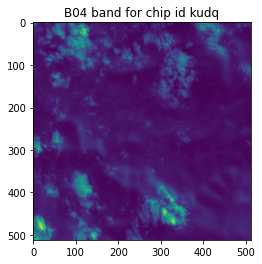

In [20]:
plt.imshow(img_array)
plt.title(f"B04 band for chip id {example_chip.chip_id}")
plt.show()

In [21]:
# longitude/latitude of image's center
with rasterio.open(example_chip["B04_path"]) as img:
    lon, lat = img.lnglat()
    bounds = img.bounds
print(f"Longitude: {lon}, latitude: {lat}")

Longitude: -52.615982199160364, latitude: -29.46353304963184


In [22]:
bounds

BoundingBox(left=340740.0, bottom=6737010.0, right=345860.0, top=6742130.0)

In [23]:
def lat_long_bounds(filepath):
    """Given the path to a GeoTIFF, returns the image bounds in latitude and
    longitude coordinates.

    Returns points as a tuple of (left, bottom, right, top)
    """
    with rasterio.open(filepath) as im:
        bounds = im.bounds
        meta = im.meta
    # create a converter starting with the current projection
    current_crs = pyproj.CRS(meta["crs"])
    crs_transform = pyproj.Transformer.from_crs(current_crs, current_crs.geodetic_crs)

    # returns left, bottom, right, top
    return crs_transform.transform_bounds(*bounds)
left, bottom, right, top = lat_long_bounds(example_chip["B04_path"])
print(
    f"Image coordinates (lat, long):\nStart: ({left}, {bottom})"
    f"\nEnd: ({right}, {top})"
)

Image coordinates (lat, long):
Start: (-29.486946830796455, -52.6427458966144)
End: (-29.44011455494337, -52.589230450963804)


In [24]:
def get_xarray(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])


def true_color_img(chip_id, data_dir="data/train_features"):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    chip_dir = f"{data_dir}/{chip_id}"
    red = get_xarray(f"{chip_dir}/B04.tif")
    green = get_xarray(f"{chip_dir}/B03.tif")
    blue = get_xarray(f"{chip_dir}/B02.tif")

    return ms.true_color(r=red, g=green, b=blue)

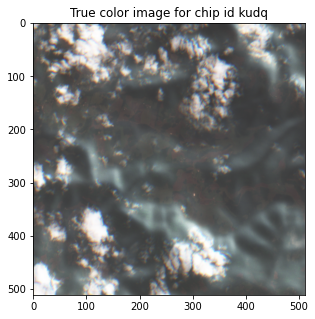

In [25]:
fig, ax = plt.subplots(figsize=(5, 5))
im = true_color_img(example_chip.chip_id)
ax.imshow(im)
plt.title(f"True color image for chip id {example_chip.chip_id}")
plt.show()

In [26]:
def display_random_chip(random_state):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    random_chip = train_meta.sample(random_state=random_state).iloc[0]
    ax[0].imshow(true_color_img(random_chip.chip_id))
    ax[0].set_title(f"Chip {random_chip.chip_id}\n(Location: {random_chip.location})")
    label_im = np.array(Image.open(random_chip.label_path))
    ax[1].imshow(label_im, cmap="gray")
    ax[1].set_title(f"Chip {random_chip.chip_id} label, {100 * (label_im.sum()/512**2):.1f}% clouds")

    plt.tight_layout()
    plt.show()

In [27]:
# for k in range(100):
#     display_random_chip(k)

In [28]:
train_meta = pd.read_csv("data/train_metadata.csv")
bands = ["B02", "B03", "B04", "B08"]
feature_dir = "data/train_features"
label_dir = "data/train_labels"

for band in bands:
    train_meta[f"{band}_path"] = train_meta["chip_id"].apply(lambda x: f"{feature_dir}/{x}/{band}.tif")
if label_dir is not None:
    train_meta["label_path"] = train_meta["chip_id"].apply(lambda x: f"{label_dir}/{x}.tif")

In [29]:
folds = [0, 1, 2, 3, 4] * (len(train_meta) // 5 + 1)
folds = folds[:len(train_meta)]

seed = 1337
np.random.seed(seed)
np.random.shuffle(folds)

In [30]:
train_meta["fold"] = folds
train_meta.sample(5)

,chip_id,location,datetime,cloudpath,B02_path,B03_path,B04_path,B08_path,label_path,fold
4428,jxti,Australia - Central West,2020-09-02T02:06:04Z,az://./train_features/jxti,data/train_features/jxti/B02.tif,data/train_features/jxti/B03.tif,data/train_features/jxti/B04.tif,data/train_features/jxti/B08.tif,data/train_labels/jxti.tif,1
2760,ewyz,Ethiopia,2020-09-12T08:39:12Z,az://./train_features/ewyz,data/train_features/ewyz/B02.tif,data/train_features/ewyz/B03.tif,data/train_features/ewyz/B04.tif,data/train_features/ewyz/B08.tif,data/train_labels/ewyz.tif,1
10558,xrft,Malemba Nkulu,2020-09-07T08:42:26Z,az://./train_features/xrft,data/train_features/xrft/B02.tif,data/train_features/xrft/B03.tif,data/train_features/xrft/B04.tif,data/train_features/xrft/B08.tif,data/train_labels/xrft.tif,3
7317,rcbj,Lusaka,2020-08-22T08:24:41Z,az://./train_features/rcbj,data/train_features/rcbj/B02.tif,data/train_features/rcbj/B03.tif,data/train_features/rcbj/B04.tif,data/train_features/rcbj/B08.tif,data/train_labels/rcbj.tif,1
6783,pibw,Canary Islands,2020-05-15T11:53:46Z,az://./train_features/pibw,data/train_features/pibw/B02.tif,data/train_features/pibw/B03.tif,data/train_features/pibw/B04.tif,data/train_features/pibw/B08.tif,data/train_labels/pibw.tif,1


In [31]:
train_meta["path_exists"] = train_meta["B02_path"].apply(lambda x: os.path.exists(x))
train_meta = train_meta[train_meta["path_exists"]==True]
train_meta.shape

(11748, 11)

In [33]:
train_meta.to_pickle("data/trainval_2021_12_30.pkl")

# Resize additional bands

In [48]:
df = pd.read_csv("data/train_metadata.csv")
new_bands = ['B01', 'B09', 'B11', 'B12']
feature_dir = "data/train_features"
label_dir = "data/train_labels"

for band in new_bands:
    df[f"{band}_path"] = df["chip_id"].apply(lambda x: f"{feature_dir}/{x}/{band}.tif")
    df[f"{band}_path_exists"] = df[f"{band}_path"].apply(lambda x: os.path.exists(x))
    print(df[f"{band}_path_exists"].value_counts())
    
paths_b1 = df["B01_path"].tolist()

True    11748
Name: B01_path_exists, dtype: int64
True    11748
Name: B09_path_exists, dtype: int64
True    11748
Name: B11_path_exists, dtype: int64
True    11748
Name: B12_path_exists, dtype: int64


In [44]:
visualize = False

def resize_and_save(idx):
    if idx%1000==999: print(idx)
        
    path_b1 = paths_b1[idx]
    resized_b1_output_path = path_b1.replace(".tif", "_resized512.tif")
    for band in new_bands:
        output_path = resized_b1_output_path.replace("B01_resized512.tif", f"{band}_resized512.tif")
#         if os.path.exists(output_path):
#             continue
        input_path = path_b1.replace("B01.tif", f"{band}.tif")
        img = tifffile.imread(input_path)
        if visualize:
            plt.imshow(img)
            plt.show()
            print(img.shape)
        img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_CUBIC)
        if visualize:
            print(img.shape)
            plt.imshow(img)
            plt.show()
        
        if input_path != output_path:
            tifffile.imwrite(output_path, img)

In [33]:
resize_and_save(2)

In [45]:
with ProcessPoolExecutor(cpus) as e: 
    e.map(resize_and_save, list(range(len(paths_b1))))

999
1999
2999
3999
4999
5999
6999
7999
8999
9999
10999


In [47]:
df = pd.read_csv("data/train_metadata.csv")
new_bands = ['B01', 'B09', 'B11', 'B12']
feature_dir = "data/train_features"
label_dir = "data/train_labels"

for band in new_bands:
    df[f"{band}_path"] = df["chip_id"].apply(lambda x: f"{feature_dir}/{x}/{band}_resized512.tif")
    df[f"{band}_path_exists"] = df[f"{band}_path"].apply(lambda x: os.path.exists(x))
    print(df[f"{band}_path_exists"].value_counts())

True    11748
Name: B01_path_exists, dtype: int64
True    11748
Name: B09_path_exists, dtype: int64
True    11748
Name: B11_path_exists, dtype: int64
True    11748
Name: B12_path_exists, dtype: int64


# Split

In [83]:
df = pd.read_csv("data/train_metadata.csv")
bands = ["B02", "B03", "B04", "B08"]
new_bands = ['B01', 'B09', 'B11', 'B12']
feature_dir = "data/train_features"
label_dir = "data/train_labels"

for band in bands:
    df[f"{band}_path"] = df["chip_id"].apply(lambda x: f"{feature_dir}/{x}/{band}.tif")
    df[f"{band}_path_exists"] = df[f"{band}_path"].apply(lambda x: os.path.exists(x))
    print(df[f"{band}_path_exists"].value_counts())
    
for band in new_bands:
    df[f"{band}_path"] = df["chip_id"].apply(lambda x: f"{feature_dir}/{x}/{band}_resized512.tif")
    df[f"{band}_path_exists"] = df[f"{band}_path"].apply(lambda x: os.path.exists(x))
    print(df[f"{band}_path_exists"].value_counts())

True    11748
Name: B02_path_exists, dtype: int64
True    11748
Name: B03_path_exists, dtype: int64
True    11748
Name: B04_path_exists, dtype: int64
True    11748
Name: B08_path_exists, dtype: int64
True    11748
Name: B01_path_exists, dtype: int64
True    11748
Name: B09_path_exists, dtype: int64
True    11748
Name: B11_path_exists, dtype: int64
True    11748
Name: B12_path_exists, dtype: int64


In [84]:
df["label_path"] = df["chip_id"].apply(lambda x: f"{label_dir}/{x}.tif")

folds = [0, 1, 2, 3, 4] * (len(df) // 5 + 1)
folds = folds[:len(df)]

seed = 11111
np.random.seed(seed)
np.random.shuffle(folds)
df["fold"] = folds

df["label_path"] = df["label_path"].apply(lambda x: x.replace(".tif", "_improved_weakly.tif") if os.path.exists(x.replace(".tif", "_improved_weakly.tif")) else x)
df["label_path"] = df["label_path"].apply(lambda x: x.replace(".tif", "_improved.tif") if os.path.exists(x.replace(".tif", "_improved.tif")) else x)
df["label_path"].apply(lambda x: os.path.exists(x)).sum()

11748

In [92]:
df["label_path"].sample(10)

5322     data/train_labels/mbhf_improved_weakly.tif
7283     data/train_labels/razr_improved_weakly.tif
443      data/train_labels/aqek_improved_weakly.tif
7988            data/train_labels/snal_improved.tif
11318    data/train_labels/yuig_improved_weakly.tif
2790     data/train_labels/exvn_improved_weakly.tif
11074    data/train_labels/yknh_improved_weakly.tif
11535    data/train_labels/zaub_improved_weakly.tif
4968                     data/train_labels/lpvc.tif
3093     data/train_labels/ghcp_improved_weakly.tif
Name: label_path, dtype: object

In [93]:
counts = df["location"].value_counts().reset_index()
# counts

In [94]:
df["weight"] = 1
power = 0.0
max_ = counts["location"].max()
for idx, row in counts.iterrows():
    df.loc[df["location"]==row["index"], "weight"] *= (max_ / row["location"]) ** power
    print(f"Setting {row['index']:30} to {(max_ / row['location']) ** power:.1f}")

Setting Chifunfu                       to 1.0
Setting Timbuktu                       to 1.0
Setting Chingola                       to 1.0
Setting Lusaka                         to 1.0
Setting Bambesa                        to 1.0
Setting South America - Brazil         to 1.0
Setting Canary Islands                 to 1.0
Setting Port Gentil                    to 1.0
Setting Uganda                         to 1.0
Setting Australia - Central            to 1.0
Setting Malabo                         to 1.0
Setting Jimma                          to 1.0
Setting Pibor                          to 1.0
Setting South America - Suriname       to 1.0
Setting Isiro                          to 1.0
Setting San Lorenzo                    to 1.0
Setting Eswatini                       to 1.0
Setting Riobamba                       to 1.0
Setting South America - Peru           to 1.0
Setting Porto Velho                    to 1.0
Setting Australia - North West         to 1.0
Setting Matadi                    

In [95]:
df.to_pickle("data/trainval_2022_01_27.pkl")

In [5]:
df["label_path"].apply(lambda x: os.path.exists(x)).sum()

11735

In [6]:
df["label_path"] = df["label_path"].apply(lambda x: x if os.path.exists(x) else x.replace("_improved.tif", ".tif"))
df["label_path"].apply(lambda x: os.path.exists(x)).sum()

11748

In [7]:
df.to_pickle("data/trainval_2022_02_05.pkl")

# Train

In [2]:
exp_nb = "7-4"
path = 'data/trainval_2022_02_05.pkl' #'data/trainval_2021_12_31.pkl'

hps_dict = {
    ############
    # Data
    ############
    "df_path": path,

    ############
    # Training
    ############

    ## Experiment Setup
    "name": f"Exp{exp_nb}",

    ## Model
    "num_classes": 1,
    "input_channel": 4,
    "backbone": "timm_efficientnet_b1",
    "pretrained": 1,
    "model": "unet",

    # Training Setup
#     "resume": "trained_models/Exp7-4/fold_0/2022-02-05_23-13-25/best_metric_18_0.9768.pt",
    "print_freq": 1000,
    "use_fp16": 1,
    "patience": 5,

    # Optimizer
    "lr": 0.0001,
    "weight_decay": 0.0,

    ## Data Augmentation on CPU
    "train_crop_size": 384,
    "train_batch_size": 32,
    "cutmix_alpha": 0,
    "da_brightness_magnitude": 0.0,
    "da_contrast_magnitude": 0.0,

    # Data Augmentation on GPU
    "gpu_da_params": [0.25],
    
    ### Loss, Metric
    "alpha": 0,
#     "loss": "lovasz",
           }

for fold_nb in range(5):
    hps = HyperParams(**hps_dict)
    hps.fold_nb = fold_nb
    num_batches = 8000 // (32 * torch.cuda.device_count())
    hps.num_batches = num_batches
    train_dataset, train_loader, val_dataset, val_loader = get_dataloaders(hps)
#     continue

    best_metric, best_metric_epoch = train(hps, train_loader, val_loader)

05-Feb-22 23:24:01 - Training with 1 GPUS


Train Data Augmentations: [RandomCrop(always_apply=False, p=1.0, height=384, width=384)]
Train Image Data Augmentations: []
####################################################################################################
####################################################################################################
Fold 0 --> Train: 9398, Val: 2350
####################################################################################################
Last 5 sample weights: [1.0, 1.0, 1.0, 1.0, 1.0]
unet timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None


05-Feb-22 23:24:03 - Training is done with mixed precision
05-Feb-22 23:25:16 - Ep: [1] TotalT: 1.2 min, BatchT: 0.292s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.1407
05-Feb-22 23:25:30 - Ep: [1]  ValT: 0.23 min, BatchT: 0.183s, DataT: 0.015s, Loss: 0.0553, IoU: 0.9376 (val)
05-Feb-22 23:26:38 - Ep: [2] TotalT: 2.6 min, BatchT: 0.271s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0498
05-Feb-22 23:26:48 - Ep: [2]  ValT: 0.17 min, BatchT: 0.141s, DataT: 0.015s, Loss: 0.0373, IoU: 0.9478 (val)
05-Feb-22 23:27:57 - Ep: [3] TotalT: 3.9 min, BatchT: 0.270s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0373
05-Feb-22 23:28:06 - Ep: [3]  ValT: 0.16 min, BatchT: 0.133s, DataT: 0.012s, Loss: 0.0298, IoU: 0.9542 (val)
05-Feb-22 23:29:15 - Ep: [4] TotalT: 5.2 min, BatchT: 0.271s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0321
05-Feb-22 23:29:25 - Ep: [4]  ValT: 0.16 min, BatchT: 0.133s, DataT: 0.013s, Loss: 0.0268, IoU: 0.9572 (val)
05-Feb-22 23:30:32 - Ep: [5] TotalT: 6.5 min, BatchT: 0.269s, DataT: 0.003s, GpuD

Epoch    22: reducing learning rate of group 0 to 5.0000e-05.


06-Feb-22 00:02:04 - Ep: [29] TotalT: 38.0 min, BatchT: 0.273s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0131
06-Feb-22 00:02:14 - Ep: [29]  ValT: 0.17 min, BatchT: 0.136s, DataT: 0.015s, Loss: 0.0150, IoU: 0.9724 (val)
06-Feb-22 00:03:22 - Ep: [30] TotalT: 39.3 min, BatchT: 0.271s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0128
06-Feb-22 00:03:32 - Ep: [30]  ValT: 0.17 min, BatchT: 0.136s, DataT: 0.013s, Loss: 0.0145, IoU: 0.9735 (val)
06-Feb-22 00:04:41 - Ep: [31] TotalT: 40.6 min, BatchT: 0.273s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0125
06-Feb-22 00:04:51 - Ep: [31]  ValT: 0.17 min, BatchT: 0.136s, DataT: 0.013s, Loss: 0.0150, IoU: 0.9724 (val)
06-Feb-22 00:05:59 - Ep: [32] TotalT: 41.9 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0127
06-Feb-22 00:06:09 - Ep: [32]  ValT: 0.17 min, BatchT: 0.139s, DataT: 0.014s, Loss: 0.0145, IoU: 0.9735 (val)
06-Feb-22 00:07:17 - Ep: [33] TotalT: 43.2 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0127
06-Feb-22 00:07:27 -

Epoch    28: reducing learning rate of group 0 to 2.5000e-05.


06-Feb-22 00:09:54 - Ep: [35] TotalT: 45.9 min, BatchT: 0.273s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0123
06-Feb-22 00:10:05 - Ep: [35]  ValT: 0.18 min, BatchT: 0.146s, DataT: 0.017s, Loss: 0.0141, IoU: 0.9741 (val)
06-Feb-22 00:11:14 - Ep: [36] TotalT: 47.2 min, BatchT: 0.273s, DataT: 0.004s, GpuDaT: 0.003s, Loss: 0.0116
06-Feb-22 00:11:24 - Ep: [36]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.014s, Loss: 0.0139, IoU: 0.9746 (val)
06-Feb-22 00:12:32 - Ep: [37] TotalT: 48.5 min, BatchT: 0.272s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0124
06-Feb-22 00:12:43 - Ep: [37]  ValT: 0.17 min, BatchT: 0.137s, DataT: 0.012s, Loss: 0.0140, IoU: 0.9742 (val)
06-Feb-22 00:13:51 - Ep: [38] TotalT: 49.8 min, BatchT: 0.272s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0117
06-Feb-22 00:14:02 - Ep: [38]  ValT: 0.17 min, BatchT: 0.140s, DataT: 0.012s, Loss: 0.0138, IoU: 0.9747 (val)
06-Feb-22 00:15:11 - Ep: [39] TotalT: 51.1 min, BatchT: 0.274s, DataT: 0.004s, GpuDaT: 0.003s, Loss: 0.0116
06-Feb-22 00:15:21 -

Epoch    36: reducing learning rate of group 0 to 1.2500e-05.


06-Feb-22 00:20:26 - Ep: [43] TotalT: 56.4 min, BatchT: 0.272s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0119
06-Feb-22 00:20:36 - Ep: [43]  ValT: 0.17 min, BatchT: 0.135s, DataT: 0.013s, Loss: 0.0140, IoU: 0.9743 (val)
06-Feb-22 00:21:45 - Ep: [44] TotalT: 57.7 min, BatchT: 0.271s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0115
06-Feb-22 00:21:55 - Ep: [44]  ValT: 0.17 min, BatchT: 0.140s, DataT: 0.018s, Loss: 0.0139, IoU: 0.9745 (val)
06-Feb-22 00:23:03 - Ep: [45] TotalT: 59.0 min, BatchT: 0.272s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0116
06-Feb-22 00:23:14 - Ep: [45]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.013s, Loss: 0.0138, IoU: 0.9745 (val)
06-Feb-22 00:24:22 - Ep: [46] TotalT: 60.3 min, BatchT: 0.271s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0113
06-Feb-22 00:24:33 - Ep: [46]  ValT: 0.18 min, BatchT: 0.142s, DataT: 0.015s, Loss: 0.0136, IoU: 0.9749 (val)
06-Feb-22 00:25:41 - Ep: [47] TotalT: 61.6 min, BatchT: 0.274s, DataT: 0.004s, GpuDaT: 0.003s, Loss: 0.0117
06-Feb-22 00:25:52 -

Epoch    42: reducing learning rate of group 0 to 6.2500e-06.


06-Feb-22 00:28:20 - Ep: [49] TotalT: 64.3 min, BatchT: 0.273s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0112
06-Feb-22 00:28:31 - Ep: [49]  ValT: 0.17 min, BatchT: 0.141s, DataT: 0.013s, Loss: 0.0137, IoU: 0.9748 (val)
06-Feb-22 00:29:39 - Ep: [50] TotalT: 65.6 min, BatchT: 0.274s, DataT: 0.004s, GpuDaT: 0.003s, Loss: 0.0115
06-Feb-22 00:29:50 - Ep: [50]  ValT: 0.18 min, BatchT: 0.142s, DataT: 0.017s, Loss: 0.0137, IoU: 0.9747 (val)
06-Feb-22 00:30:58 - Ep: [51] TotalT: 66.9 min, BatchT: 0.271s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0114
06-Feb-22 00:31:08 - Ep: [51]  ValT: 0.16 min, BatchT: 0.132s, DataT: 0.012s, Loss: 0.0137, IoU: 0.9747 (val)
06-Feb-22 00:32:17 - Ep: [52] TotalT: 68.2 min, BatchT: 0.272s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0110
06-Feb-22 00:32:27 - Ep: [52]  ValT: 0.18 min, BatchT: 0.142s, DataT: 0.018s, Loss: 0.0137, IoU: 0.9748 (val)
06-Feb-22 00:32:27 - Early Stopping
06-Feb-22 00:32:27 - Best validation combination metric of 0.97501 in epoch 39.
06-Feb-22 00

Train Data Augmentations: [RandomCrop(always_apply=False, p=1.0, height=384, width=384)]
Train Image Data Augmentations: []
####################################################################################################
####################################################################################################
Fold 1 --> Train: 9398, Val: 2350
####################################################################################################
Last 5 sample weights: [1.0, 1.0, 1.0, 1.0, 1.0]
unet timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None


06-Feb-22 00:33:35 - Ep: [1] TotalT: 1.1 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.1252
06-Feb-22 00:33:45 - Ep: [1]  ValT: 0.17 min, BatchT: 0.137s, DataT: 0.012s, Loss: 0.0540, IoU: 0.9406 (val)
06-Feb-22 00:34:53 - Ep: [2] TotalT: 2.4 min, BatchT: 0.269s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0476
06-Feb-22 00:35:04 - Ep: [2]  ValT: 0.18 min, BatchT: 0.143s, DataT: 0.018s, Loss: 0.0357, IoU: 0.9519 (val)
06-Feb-22 00:36:11 - Ep: [3] TotalT: 3.7 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0370
06-Feb-22 00:36:21 - Ep: [3]  ValT: 0.16 min, BatchT: 0.133s, DataT: 0.013s, Loss: 0.0300, IoU: 0.9556 (val)
06-Feb-22 00:37:29 - Ep: [4] TotalT: 5.0 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0322
06-Feb-22 00:37:39 - Ep: [4]  ValT: 0.17 min, BatchT: 0.134s, DataT: 0.014s, Loss: 0.0267, IoU: 0.9585 (val)
06-Feb-22 00:38:46 - Ep: [5] TotalT: 6.3 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0283
06-Feb-22 00:38:57 - Ep: [5]  ValT

Epoch    19: reducing learning rate of group 0 to 5.0000e-05.


06-Feb-22 01:06:08 - Ep: [26] TotalT: 33.7 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0142
06-Feb-22 01:06:19 - Ep: [26]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.018s, Loss: 0.0139, IoU: 0.9759 (val)
06-Feb-22 01:07:26 - Ep: [27] TotalT: 35.0 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0141
06-Feb-22 01:07:37 - Ep: [27]  ValT: 0.17 min, BatchT: 0.136s, DataT: 0.014s, Loss: 0.0138, IoU: 0.9759 (val)
06-Feb-22 01:08:45 - Ep: [28] TotalT: 36.3 min, BatchT: 0.270s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0136
06-Feb-22 01:08:55 - Ep: [28]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.013s, Loss: 0.0137, IoU: 0.9761 (val)
06-Feb-22 01:10:03 - Ep: [29] TotalT: 37.6 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0134
06-Feb-22 01:10:13 - Ep: [29]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.014s, Loss: 0.0145, IoU: 0.9748 (val)
06-Feb-22 01:11:20 - Ep: [30] TotalT: 38.9 min, BatchT: 0.268s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0132
06-Feb-22 01:11:31 -

Epoch    26: reducing learning rate of group 0 to 2.5000e-05.


06-Feb-22 01:15:14 - Ep: [33] TotalT: 42.8 min, BatchT: 0.271s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0131
06-Feb-22 01:15:25 - Ep: [33]  ValT: 0.17 min, BatchT: 0.139s, DataT: 0.015s, Loss: 0.0133, IoU: 0.9767 (val)
06-Feb-22 01:16:33 - Ep: [34] TotalT: 44.1 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0127
06-Feb-22 01:16:43 - Ep: [34]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.014s, Loss: 0.0131, IoU: 0.9769 (val)
06-Feb-22 01:17:51 - Ep: [35] TotalT: 45.4 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0122
06-Feb-22 01:18:01 - Ep: [35]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.013s, Loss: 0.0132, IoU: 0.9768 (val)
06-Feb-22 01:19:09 - Ep: [36] TotalT: 46.7 min, BatchT: 0.271s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0126
06-Feb-22 01:19:20 - Ep: [36]  ValT: 0.18 min, BatchT: 0.144s, DataT: 0.017s, Loss: 0.0128, IoU: 0.9776 (val)
06-Feb-22 01:20:28 - Ep: [37] TotalT: 48.0 min, BatchT: 0.270s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0121
06-Feb-22 01:20:39 -

Epoch    36: reducing learning rate of group 0 to 1.2500e-05.


06-Feb-22 01:28:18 - Ep: [43] TotalT: 55.8 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0117
06-Feb-22 01:28:29 - Ep: [43]  ValT: 0.17 min, BatchT: 0.141s, DataT: 0.015s, Loss: 0.0128, IoU: 0.9775 (val)
06-Feb-22 01:29:36 - Ep: [44] TotalT: 57.1 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0119
06-Feb-22 01:29:46 - Ep: [44]  ValT: 0.16 min, BatchT: 0.133s, DataT: 0.011s, Loss: 0.0128, IoU: 0.9776 (val)
06-Feb-22 01:30:53 - Ep: [45] TotalT: 58.4 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0120
06-Feb-22 01:31:04 - Ep: [45]  ValT: 0.17 min, BatchT: 0.137s, DataT: 0.016s, Loss: 0.0128, IoU: 0.9776 (val)
06-Feb-22 01:32:11 - Ep: [46] TotalT: 59.7 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0118
06-Feb-22 01:32:22 - Ep: [46]  ValT: 0.18 min, BatchT: 0.147s, DataT: 0.020s, Loss: 0.0128, IoU: 0.9776 (val)
06-Feb-22 01:33:29 - Ep: [47] TotalT: 61.0 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0119
06-Feb-22 01:33:40 -

Epoch    42: reducing learning rate of group 0 to 6.2500e-06.


06-Feb-22 01:36:07 - Ep: [49] TotalT: 63.7 min, BatchT: 0.272s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0117
06-Feb-22 01:36:17 - Ep: [49]  ValT: 0.17 min, BatchT: 0.140s, DataT: 0.013s, Loss: 0.0130, IoU: 0.9772 (val)
06-Feb-22 01:37:25 - Ep: [50] TotalT: 65.0 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0118
06-Feb-22 01:37:35 - Ep: [50]  ValT: 0.17 min, BatchT: 0.139s, DataT: 0.015s, Loss: 0.0127, IoU: 0.9778 (val)
06-Feb-22 01:38:43 - Ep: [51] TotalT: 66.3 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0117
06-Feb-22 01:38:54 - Ep: [51]  ValT: 0.17 min, BatchT: 0.140s, DataT: 0.014s, Loss: 0.0126, IoU: 0.9779 (val)
06-Feb-22 01:40:02 - Ep: [52] TotalT: 67.6 min, BatchT: 0.271s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0115
06-Feb-22 01:40:12 - Ep: [52]  ValT: 0.17 min, BatchT: 0.140s, DataT: 0.013s, Loss: 0.0125, IoU: 0.9780 (val)
06-Feb-22 01:41:20 - Ep: [53] TotalT: 68.9 min, BatchT: 0.270s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0117
06-Feb-22 01:41:31 -

Epoch    48: reducing learning rate of group 0 to 3.1250e-06.


06-Feb-22 01:43:56 - Ep: [55] TotalT: 71.5 min, BatchT: 0.269s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0117
06-Feb-22 01:44:07 - Ep: [55]  ValT: 0.18 min, BatchT: 0.145s, DataT: 0.019s, Loss: 0.0125, IoU: 0.9780 (val)
06-Feb-22 01:45:15 - Ep: [56] TotalT: 72.8 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0115
06-Feb-22 01:45:25 - Ep: [56]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.015s, Loss: 0.0124, IoU: 0.9782 (val)
06-Feb-22 01:46:33 - Ep: [57] TotalT: 74.1 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0112
06-Feb-22 01:46:43 - Ep: [57]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.014s, Loss: 0.0124, IoU: 0.9782 (val)
06-Feb-22 01:47:51 - Ep: [58] TotalT: 75.4 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0117
06-Feb-22 01:48:01 - Ep: [58]  ValT: 0.17 min, BatchT: 0.139s, DataT: 0.015s, Loss: 0.0125, IoU: 0.9780 (val)
06-Feb-22 01:49:09 - Ep: [59] TotalT: 76.7 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0115
06-Feb-22 01:49:20 -

Epoch    54: reducing learning rate of group 0 to 1.5625e-06.


06-Feb-22 01:51:47 - Ep: [61] TotalT: 79.3 min, BatchT: 0.273s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0114
06-Feb-22 01:51:57 - Ep: [61]  ValT: 0.17 min, BatchT: 0.135s, DataT: 0.013s, Loss: 0.0125, IoU: 0.9780 (val)
06-Feb-22 01:53:04 - Ep: [62] TotalT: 80.6 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0115
06-Feb-22 01:53:15 - Ep: [62]  ValT: 0.18 min, BatchT: 0.142s, DataT: 0.016s, Loss: 0.0125, IoU: 0.9780 (val)
06-Feb-22 01:54:23 - Ep: [63] TotalT: 81.9 min, BatchT: 0.271s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0114
06-Feb-22 01:54:34 - Ep: [63]  ValT: 0.18 min, BatchT: 0.144s, DataT: 0.016s, Loss: 0.0126, IoU: 0.9780 (val)
06-Feb-22 01:55:41 - Ep: [64] TotalT: 83.2 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0115
06-Feb-22 01:55:52 - Ep: [64]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.013s, Loss: 0.0125, IoU: 0.9781 (val)
06-Feb-22 01:57:00 - Ep: [65] TotalT: 84.5 min, BatchT: 0.270s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0115
06-Feb-22 01:57:10 -

Epoch    60: reducing learning rate of group 0 to 7.8125e-07.
Train Data Augmentations: [RandomCrop(always_apply=False, p=1.0, height=384, width=384)]
Train Image Data Augmentations: []
####################################################################################################
####################################################################################################
Fold 2 --> Train: 9398, Val: 2350
####################################################################################################
Last 5 sample weights: [1.0, 1.0, 1.0, 1.0, 1.0]
unet timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None


06-Feb-22 01:58:29 - Training with 1 GPUS
06-Feb-22 01:58:29 - Training is done with mixed precision
06-Feb-22 01:59:36 - Ep: [1] TotalT: 1.1 min, BatchT: 0.269s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.1110
06-Feb-22 01:59:47 - Ep: [1]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.015s, Loss: 0.0459, IoU: 0.9442 (val)
06-Feb-22 02:00:54 - Ep: [2] TotalT: 2.4 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0447
06-Feb-22 02:01:04 - Ep: [2]  ValT: 0.16 min, BatchT: 0.129s, DataT: 0.012s, Loss: 0.0335, IoU: 0.9497 (val)
06-Feb-22 02:02:12 - Ep: [3] TotalT: 3.7 min, BatchT: 0.270s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0363
06-Feb-22 02:02:22 - Ep: [3]  ValT: 0.16 min, BatchT: 0.130s, DataT: 0.012s, Loss: 0.0300, IoU: 0.9532 (val)
06-Feb-22 02:03:29 - Ep: [4] TotalT: 5.0 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0309
06-Feb-22 02:03:39 - Ep: [4]  ValT: 0.16 min, BatchT: 0.131s, DataT: 0.012s, Loss: 0.0277, IoU: 0.9561 (val)
06-Feb-22 02:04:46 - Ep: [5] TotalT: 6.

Epoch    12: reducing learning rate of group 0 to 5.0000e-05.


06-Feb-22 02:22:55 - Ep: [19] TotalT: 24.4 min, BatchT: 0.267s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0160
06-Feb-22 02:23:05 - Ep: [19]  ValT: 0.17 min, BatchT: 0.135s, DataT: 0.015s, Loss: 0.0156, IoU: 0.9728 (val)
06-Feb-22 02:24:13 - Ep: [20] TotalT: 25.7 min, BatchT: 0.267s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0153
06-Feb-22 02:24:23 - Ep: [20]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.015s, Loss: 0.0156, IoU: 0.9728 (val)
06-Feb-22 02:25:31 - Ep: [21] TotalT: 27.0 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0148
06-Feb-22 02:25:41 - Ep: [21]  ValT: 0.17 min, BatchT: 0.136s, DataT: 0.013s, Loss: 0.0150, IoU: 0.9738 (val)
06-Feb-22 02:26:49 - Ep: [22] TotalT: 28.3 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0153
06-Feb-22 02:26:59 - Ep: [22]  ValT: 0.17 min, BatchT: 0.135s, DataT: 0.013s, Loss: 0.0149, IoU: 0.9740 (val)
06-Feb-22 02:28:07 - Ep: [23] TotalT: 29.6 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0146
06-Feb-22 02:28:17 -

Epoch    19: reducing learning rate of group 0 to 2.5000e-05.


06-Feb-22 02:32:01 - Ep: [26] TotalT: 33.5 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0142
06-Feb-22 02:32:11 - Ep: [26]  ValT: 0.17 min, BatchT: 0.140s, DataT: 0.014s, Loss: 0.0147, IoU: 0.9745 (val)
06-Feb-22 02:33:19 - Ep: [27] TotalT: 34.8 min, BatchT: 0.269s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0144
06-Feb-22 02:33:29 - Ep: [27]  ValT: 0.16 min, BatchT: 0.134s, DataT: 0.013s, Loss: 0.0146, IoU: 0.9744 (val)
06-Feb-22 02:34:37 - Ep: [28] TotalT: 36.1 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0139
06-Feb-22 02:34:47 - Ep: [28]  ValT: 0.17 min, BatchT: 0.134s, DataT: 0.013s, Loss: 0.0145, IoU: 0.9746 (val)
06-Feb-22 02:35:55 - Ep: [29] TotalT: 37.4 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0136
06-Feb-22 02:36:05 - Ep: [29]  ValT: 0.16 min, BatchT: 0.133s, DataT: 0.014s, Loss: 0.0144, IoU: 0.9748 (val)
06-Feb-22 02:37:13 - Ep: [30] TotalT: 38.7 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0139
06-Feb-22 02:37:23 -

Epoch    26: reducing learning rate of group 0 to 1.2500e-05.


06-Feb-22 02:41:05 - Ep: [33] TotalT: 42.6 min, BatchT: 0.269s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0133
06-Feb-22 02:41:15 - Ep: [33]  ValT: 0.17 min, BatchT: 0.134s, DataT: 0.014s, Loss: 0.0144, IoU: 0.9747 (val)
06-Feb-22 02:42:23 - Ep: [34] TotalT: 43.9 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0134
06-Feb-22 02:42:33 - Ep: [34]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.012s, Loss: 0.0142, IoU: 0.9750 (val)
06-Feb-22 02:43:41 - Ep: [35] TotalT: 45.2 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0133
06-Feb-22 02:43:51 - Ep: [35]  ValT: 0.17 min, BatchT: 0.135s, DataT: 0.014s, Loss: 0.0143, IoU: 0.9750 (val)
06-Feb-22 02:44:59 - Ep: [36] TotalT: 46.5 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0135
06-Feb-22 02:45:09 - Ep: [36]  ValT: 0.18 min, BatchT: 0.142s, DataT: 0.016s, Loss: 0.0142, IoU: 0.9751 (val)
06-Feb-22 02:46:18 - Ep: [37] TotalT: 47.8 min, BatchT: 0.271s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0133
06-Feb-22 02:46:28 -

Epoch    32: reducing learning rate of group 0 to 6.2500e-06.


06-Feb-22 02:48:54 - Ep: [39] TotalT: 50.4 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0131
06-Feb-22 02:49:05 - Ep: [39]  ValT: 0.18 min, BatchT: 0.144s, DataT: 0.018s, Loss: 0.0139, IoU: 0.9757 (val)
06-Feb-22 02:50:13 - Ep: [40] TotalT: 51.7 min, BatchT: 0.270s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0128
06-Feb-22 02:50:23 - Ep: [40]  ValT: 0.17 min, BatchT: 0.136s, DataT: 0.013s, Loss: 0.0140, IoU: 0.9754 (val)
06-Feb-22 02:51:30 - Ep: [41] TotalT: 53.0 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0129
06-Feb-22 02:51:41 - Ep: [41]  ValT: 0.17 min, BatchT: 0.142s, DataT: 0.016s, Loss: 0.0141, IoU: 0.9753 (val)
06-Feb-22 02:52:49 - Ep: [42] TotalT: 54.3 min, BatchT: 0.270s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0130
06-Feb-22 02:52:59 - Ep: [42]  ValT: 0.17 min, BatchT: 0.136s, DataT: 0.012s, Loss: 0.0139, IoU: 0.9757 (val)
06-Feb-22 02:54:07 - Ep: [43] TotalT: 55.6 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0129
06-Feb-22 02:54:18 -

Epoch    38: reducing learning rate of group 0 to 3.1250e-06.


06-Feb-22 02:56:43 - Ep: [45] TotalT: 58.2 min, BatchT: 0.270s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0131
06-Feb-22 02:56:53 - Ep: [45]  ValT: 0.16 min, BatchT: 0.133s, DataT: 0.013s, Loss: 0.0139, IoU: 0.9756 (val)
06-Feb-22 02:58:00 - Ep: [46] TotalT: 59.5 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0130
06-Feb-22 02:58:11 - Ep: [46]  ValT: 0.17 min, BatchT: 0.141s, DataT: 0.014s, Loss: 0.0139, IoU: 0.9755 (val)
06-Feb-22 02:59:19 - Ep: [47] TotalT: 60.8 min, BatchT: 0.271s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0131
06-Feb-22 02:59:29 - Ep: [47]  ValT: 0.17 min, BatchT: 0.137s, DataT: 0.015s, Loss: 0.0139, IoU: 0.9756 (val)
06-Feb-22 03:00:37 - Ep: [48] TotalT: 62.1 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0132
06-Feb-22 03:00:47 - Ep: [48]  ValT: 0.17 min, BatchT: 0.134s, DataT: 0.012s, Loss: 0.0139, IoU: 0.9756 (val)
06-Feb-22 03:01:55 - Ep: [49] TotalT: 63.4 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0132
06-Feb-22 03:02:05 -

Epoch    44: reducing learning rate of group 0 to 1.5625e-06.


06-Feb-22 03:04:31 - Ep: [51] TotalT: 66.0 min, BatchT: 0.269s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0128
06-Feb-22 03:04:42 - Ep: [51]  ValT: 0.17 min, BatchT: 0.136s, DataT: 0.014s, Loss: 0.0138, IoU: 0.9758 (val)
06-Feb-22 03:05:49 - Ep: [52] TotalT: 67.3 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0129
06-Feb-22 03:06:00 - Ep: [52]  ValT: 0.17 min, BatchT: 0.141s, DataT: 0.013s, Loss: 0.0138, IoU: 0.9758 (val)
06-Feb-22 03:06:00 - Early Stopping
06-Feb-22 03:06:00 - Best validation combination metric of 0.97580 in epoch 52.


Train Data Augmentations: [RandomCrop(always_apply=False, p=1.0, height=384, width=384)]
Train Image Data Augmentations: []
####################################################################################################
####################################################################################################
Fold 3 --> Train: 9399, Val: 2349
####################################################################################################
Last 5 sample weights: [1.0, 1.0, 1.0, 1.0, 1.0]
unet timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None


06-Feb-22 03:06:01 - Training with 1 GPUS
06-Feb-22 03:06:01 - Training is done with mixed precision
06-Feb-22 03:07:09 - Ep: [1] TotalT: 1.1 min, BatchT: 0.273s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.1314
06-Feb-22 03:07:21 - Ep: [1]  ValT: 0.20 min, BatchT: 0.159s, DataT: 0.014s, Loss: 0.0550, IoU: 0.9340 (val)
06-Feb-22 03:08:30 - Ep: [2] TotalT: 2.5 min, BatchT: 0.273s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0498
06-Feb-22 03:08:41 - Ep: [2]  ValT: 0.17 min, BatchT: 0.142s, DataT: 0.015s, Loss: 0.0385, IoU: 0.9453 (val)
06-Feb-22 03:09:49 - Ep: [3] TotalT: 3.8 min, BatchT: 0.272s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0376
06-Feb-22 03:09:59 - Ep: [3]  ValT: 0.17 min, BatchT: 0.134s, DataT: 0.012s, Loss: 0.0301, IoU: 0.9525 (val)
06-Feb-22 03:11:07 - Ep: [4] TotalT: 5.1 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0322
06-Feb-22 03:11:18 - Ep: [4]  ValT: 0.17 min, BatchT: 0.142s, DataT: 0.016s, Loss: 0.0277, IoU: 0.9547 (val)
06-Feb-22 03:12:26 - Ep: [5] TotalT: 6.

Epoch    15: reducing learning rate of group 0 to 5.0000e-05.


06-Feb-22 03:34:46 - Ep: [22] TotalT: 28.8 min, BatchT: 0.271s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0145
06-Feb-22 03:34:56 - Ep: [22]  ValT: 0.17 min, BatchT: 0.139s, DataT: 0.014s, Loss: 0.0154, IoU: 0.9720 (val)
06-Feb-22 03:36:05 - Ep: [23] TotalT: 30.1 min, BatchT: 0.272s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0147
06-Feb-22 03:36:15 - Ep: [23]  ValT: 0.17 min, BatchT: 0.139s, DataT: 0.012s, Loss: 0.0149, IoU: 0.9730 (val)
06-Feb-22 03:37:24 - Ep: [24] TotalT: 31.4 min, BatchT: 0.273s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0144
06-Feb-22 03:37:35 - Ep: [24]  ValT: 0.17 min, BatchT: 0.142s, DataT: 0.018s, Loss: 0.0148, IoU: 0.9731 (val)
06-Feb-22 03:38:43 - Ep: [25] TotalT: 32.7 min, BatchT: 0.272s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0140
06-Feb-22 03:38:53 - Ep: [25]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.013s, Loss: 0.0144, IoU: 0.9740 (val)
06-Feb-22 03:40:02 - Ep: [26] TotalT: 34.0 min, BatchT: 0.272s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0140
06-Feb-22 03:40:13 -

Epoch    25: reducing learning rate of group 0 to 2.5000e-05.


06-Feb-22 03:47:56 - Ep: [32] TotalT: 41.9 min, BatchT: 0.273s, DataT: 0.005s, GpuDaT: 0.002s, Loss: 0.0128
06-Feb-22 03:48:07 - Ep: [32]  ValT: 0.17 min, BatchT: 0.137s, DataT: 0.011s, Loss: 0.0138, IoU: 0.9749 (val)
06-Feb-22 03:49:15 - Ep: [33] TotalT: 43.2 min, BatchT: 0.270s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0134
06-Feb-22 03:49:25 - Ep: [33]  ValT: 0.18 min, BatchT: 0.142s, DataT: 0.017s, Loss: 0.0135, IoU: 0.9755 (val)
06-Feb-22 03:50:33 - Ep: [34] TotalT: 44.5 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0126
06-Feb-22 03:50:44 - Ep: [34]  ValT: 0.18 min, BatchT: 0.144s, DataT: 0.017s, Loss: 0.0134, IoU: 0.9756 (val)
06-Feb-22 03:51:52 - Ep: [35] TotalT: 45.9 min, BatchT: 0.270s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0127
06-Feb-22 03:52:02 - Ep: [35]  ValT: 0.17 min, BatchT: 0.139s, DataT: 0.012s, Loss: 0.0131, IoU: 0.9761 (val)
06-Feb-22 03:53:11 - Ep: [36] TotalT: 47.2 min, BatchT: 0.272s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0126
06-Feb-22 03:53:21 -

Epoch    33: reducing learning rate of group 0 to 1.2500e-05.


06-Feb-22 03:58:26 - Ep: [40] TotalT: 52.4 min, BatchT: 0.272s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0124
06-Feb-22 03:58:37 - Ep: [40]  ValT: 0.18 min, BatchT: 0.147s, DataT: 0.019s, Loss: 0.0131, IoU: 0.9761 (val)
06-Feb-22 03:59:45 - Ep: [41] TotalT: 53.7 min, BatchT: 0.272s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0121
06-Feb-22 03:59:56 - Ep: [41]  ValT: 0.18 min, BatchT: 0.143s, DataT: 0.016s, Loss: 0.0132, IoU: 0.9761 (val)
06-Feb-22 04:01:04 - Ep: [42] TotalT: 55.1 min, BatchT: 0.271s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0123
06-Feb-22 04:01:15 - Ep: [42]  ValT: 0.18 min, BatchT: 0.149s, DataT: 0.021s, Loss: 0.0132, IoU: 0.9760 (val)
06-Feb-22 04:02:23 - Ep: [43] TotalT: 56.4 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0121
06-Feb-22 04:02:34 - Ep: [43]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.013s, Loss: 0.0137, IoU: 0.9751 (val)
06-Feb-22 04:03:42 - Ep: [44] TotalT: 57.7 min, BatchT: 0.271s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0120
06-Feb-22 04:03:52 -

Epoch    39: reducing learning rate of group 0 to 6.2500e-06.


06-Feb-22 04:06:18 - Ep: [46] TotalT: 60.3 min, BatchT: 0.271s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0119
06-Feb-22 04:06:29 - Ep: [46]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.014s, Loss: 0.0129, IoU: 0.9766 (val)
06-Feb-22 04:07:37 - Ep: [47] TotalT: 61.6 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0122
06-Feb-22 04:07:47 - Ep: [47]  ValT: 0.17 min, BatchT: 0.136s, DataT: 0.012s, Loss: 0.0129, IoU: 0.9766 (val)
06-Feb-22 04:08:55 - Ep: [48] TotalT: 62.9 min, BatchT: 0.271s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0120
06-Feb-22 04:09:05 - Ep: [48]  ValT: 0.17 min, BatchT: 0.140s, DataT: 0.015s, Loss: 0.0131, IoU: 0.9762 (val)
06-Feb-22 04:10:13 - Ep: [49] TotalT: 64.2 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0119
06-Feb-22 04:10:24 - Ep: [49]  ValT: 0.17 min, BatchT: 0.140s, DataT: 0.012s, Loss: 0.0130, IoU: 0.9763 (val)
06-Feb-22 04:11:32 - Ep: [50] TotalT: 65.5 min, BatchT: 0.273s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0122
06-Feb-22 04:11:43 -

Epoch    45: reducing learning rate of group 0 to 3.1250e-06.


06-Feb-22 04:14:10 - Ep: [52] TotalT: 68.2 min, BatchT: 0.272s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0116
06-Feb-22 04:14:21 - Ep: [52]  ValT: 0.18 min, BatchT: 0.149s, DataT: 0.020s, Loss: 0.0129, IoU: 0.9765 (val)
06-Feb-22 04:15:30 - Ep: [53] TotalT: 69.5 min, BatchT: 0.272s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0117
06-Feb-22 04:15:40 - Ep: [53]  ValT: 0.17 min, BatchT: 0.139s, DataT: 0.014s, Loss: 0.0129, IoU: 0.9766 (val)
06-Feb-22 04:16:48 - Ep: [54] TotalT: 70.8 min, BatchT: 0.271s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0116
06-Feb-22 04:16:59 - Ep: [54]  ValT: 0.17 min, BatchT: 0.139s, DataT: 0.012s, Loss: 0.0130, IoU: 0.9764 (val)
06-Feb-22 04:18:07 - Ep: [55] TotalT: 72.1 min, BatchT: 0.272s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0121
06-Feb-22 04:18:18 - Ep: [55]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.013s, Loss: 0.0130, IoU: 0.9763 (val)
06-Feb-22 04:19:25 - Ep: [56] TotalT: 73.4 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0120
06-Feb-22 04:19:36 -

Epoch    51: reducing learning rate of group 0 to 1.5625e-06.


06-Feb-22 04:22:03 - Ep: [58] TotalT: 76.0 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0120
06-Feb-22 04:22:14 - Ep: [58]  ValT: 0.17 min, BatchT: 0.140s, DataT: 0.014s, Loss: 0.0131, IoU: 0.9760 (val)
06-Feb-22 04:23:22 - Ep: [59] TotalT: 77.4 min, BatchT: 0.271s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0119
06-Feb-22 04:23:32 - Ep: [59]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.014s, Loss: 0.0131, IoU: 0.9761 (val)
06-Feb-22 04:23:32 - Early Stopping
06-Feb-22 04:23:32 - Best validation combination metric of 0.97660 in epoch 53.
06-Feb-22 04:23:32 - Training with 1 GPUS
06-Feb-22 04:23:32 - Training is done with mixed precision


Train Data Augmentations: [RandomCrop(always_apply=False, p=1.0, height=384, width=384)]
Train Image Data Augmentations: []
####################################################################################################
####################################################################################################
Fold 4 --> Train: 9399, Val: 2349
####################################################################################################
Last 5 sample weights: [1.0, 1.0, 1.0, 1.0, 1.0]
unet timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None


06-Feb-22 04:24:40 - Ep: [1] TotalT: 1.1 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.1128
06-Feb-22 04:24:51 - Ep: [1]  ValT: 0.17 min, BatchT: 0.137s, DataT: 0.012s, Loss: 0.0490, IoU: 0.9389 (val)
06-Feb-22 04:25:59 - Ep: [2] TotalT: 2.4 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0451
06-Feb-22 04:26:09 - Ep: [2]  ValT: 0.17 min, BatchT: 0.139s, DataT: 0.014s, Loss: 0.0346, IoU: 0.9478 (val)
06-Feb-22 04:27:18 - Ep: [3] TotalT: 3.8 min, BatchT: 0.273s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0360
06-Feb-22 04:27:28 - Ep: [3]  ValT: 0.17 min, BatchT: 0.140s, DataT: 0.015s, Loss: 0.0311, IoU: 0.9506 (val)
06-Feb-22 04:28:37 - Ep: [4] TotalT: 5.1 min, BatchT: 0.271s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0304
06-Feb-22 04:28:47 - Ep: [4]  ValT: 0.17 min, BatchT: 0.141s, DataT: 0.013s, Loss: 0.0274, IoU: 0.9549 (val)
06-Feb-22 04:29:56 - Ep: [5] TotalT: 6.4 min, BatchT: 0.273s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0260
06-Feb-22 04:30:07 - Ep: [5]  ValT

Epoch    13: reducing learning rate of group 0 to 5.0000e-05.


06-Feb-22 04:49:38 - Ep: [20] TotalT: 26.1 min, BatchT: 0.272s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0154
06-Feb-22 04:49:49 - Ep: [20]  ValT: 0.18 min, BatchT: 0.145s, DataT: 0.014s, Loss: 0.0172, IoU: 0.9694 (val)
06-Feb-22 04:50:58 - Ep: [21] TotalT: 27.4 min, BatchT: 0.272s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0150
06-Feb-22 04:51:08 - Ep: [21]  ValT: 0.17 min, BatchT: 0.139s, DataT: 0.015s, Loss: 0.0157, IoU: 0.9719 (val)
06-Feb-22 04:52:16 - Ep: [22] TotalT: 28.7 min, BatchT: 0.271s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0143
06-Feb-22 04:52:27 - Ep: [22]  ValT: 0.18 min, BatchT: 0.143s, DataT: 0.015s, Loss: 0.0156, IoU: 0.9721 (val)
06-Feb-22 04:53:37 - Ep: [23] TotalT: 30.1 min, BatchT: 0.276s, DataT: 0.005s, GpuDaT: 0.002s, Loss: 0.0150
06-Feb-22 04:53:47 - Ep: [23]  ValT: 0.17 min, BatchT: 0.139s, DataT: 0.016s, Loss: 0.0154, IoU: 0.9725 (val)
06-Feb-22 04:54:55 - Ep: [24] TotalT: 31.4 min, BatchT: 0.271s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0148
06-Feb-22 04:55:06 -

Epoch    21: reducing learning rate of group 0 to 2.5000e-05.


06-Feb-22 05:00:11 - Ep: [28] TotalT: 36.6 min, BatchT: 0.271s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0138
06-Feb-22 05:00:21 - Ep: [28]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.015s, Loss: 0.0148, IoU: 0.9736 (val)
06-Feb-22 05:01:29 - Ep: [29] TotalT: 37.9 min, BatchT: 0.270s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0134
06-Feb-22 05:01:39 - Ep: [29]  ValT: 0.17 min, BatchT: 0.136s, DataT: 0.013s, Loss: 0.0151, IoU: 0.9728 (val)
06-Feb-22 05:02:47 - Ep: [30] TotalT: 39.2 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0132
06-Feb-22 05:02:57 - Ep: [30]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.015s, Loss: 0.0152, IoU: 0.9729 (val)
06-Feb-22 05:04:05 - Ep: [31] TotalT: 40.5 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0131
06-Feb-22 05:04:15 - Ep: [31]  ValT: 0.17 min, BatchT: 0.136s, DataT: 0.012s, Loss: 0.0149, IoU: 0.9734 (val)
06-Feb-22 05:05:22 - Ep: [32] TotalT: 41.8 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0129
06-Feb-22 05:05:32 -

Epoch    28: reducing learning rate of group 0 to 1.2500e-05.


06-Feb-22 05:09:15 - Ep: [35] TotalT: 45.7 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0128
06-Feb-22 05:09:25 - Ep: [35]  ValT: 0.17 min, BatchT: 0.134s, DataT: 0.011s, Loss: 0.0145, IoU: 0.9738 (val)
06-Feb-22 05:10:32 - Ep: [36] TotalT: 47.0 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0129
06-Feb-22 05:10:42 - Ep: [36]  ValT: 0.17 min, BatchT: 0.136s, DataT: 0.013s, Loss: 0.0147, IoU: 0.9736 (val)
06-Feb-22 05:11:50 - Ep: [37] TotalT: 48.3 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0123
06-Feb-22 05:12:00 - Ep: [37]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.014s, Loss: 0.0148, IoU: 0.9734 (val)
06-Feb-22 05:13:07 - Ep: [38] TotalT: 49.6 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0121
06-Feb-22 05:13:18 - Ep: [38]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.013s, Loss: 0.0146, IoU: 0.9739 (val)
06-Feb-22 05:14:25 - Ep: [39] TotalT: 50.9 min, BatchT: 0.267s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0126
06-Feb-22 05:14:35 -

Epoch    34: reducing learning rate of group 0 to 6.2500e-06.


06-Feb-22 05:17:00 - Ep: [41] TotalT: 53.5 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0120
06-Feb-22 05:17:10 - Ep: [41]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.014s, Loss: 0.0146, IoU: 0.9739 (val)
06-Feb-22 05:18:18 - Ep: [42] TotalT: 54.8 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0122
06-Feb-22 05:18:28 - Ep: [42]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.014s, Loss: 0.0146, IoU: 0.9739 (val)
06-Feb-22 05:19:36 - Ep: [43] TotalT: 56.1 min, BatchT: 0.269s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0126
06-Feb-22 05:19:46 - Ep: [43]  ValT: 0.17 min, BatchT: 0.137s, DataT: 0.014s, Loss: 0.0147, IoU: 0.9735 (val)
06-Feb-22 05:20:54 - Ep: [44] TotalT: 57.4 min, BatchT: 0.269s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0122
06-Feb-22 05:21:04 - Ep: [44]  ValT: 0.17 min, BatchT: 0.137s, DataT: 0.013s, Loss: 0.0145, IoU: 0.9739 (val)
06-Feb-22 05:22:11 - Ep: [45] TotalT: 58.6 min, BatchT: 0.267s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0125
06-Feb-22 05:22:21 -

Epoch    40: reducing learning rate of group 0 to 3.1250e-06.


06-Feb-22 05:24:46 - Ep: [47] TotalT: 61.2 min, BatchT: 0.267s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0123
06-Feb-22 05:24:56 - Ep: [47]  ValT: 0.17 min, BatchT: 0.135s, DataT: 0.012s, Loss: 0.0144, IoU: 0.9742 (val)
06-Feb-22 05:26:03 - Ep: [48] TotalT: 62.5 min, BatchT: 0.267s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0123
06-Feb-22 05:26:14 - Ep: [48]  ValT: 0.17 min, BatchT: 0.136s, DataT: 0.013s, Loss: 0.0145, IoU: 0.9740 (val)
06-Feb-22 05:27:21 - Ep: [49] TotalT: 63.8 min, BatchT: 0.267s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0120
06-Feb-22 05:27:31 - Ep: [49]  ValT: 0.17 min, BatchT: 0.137s, DataT: 0.014s, Loss: 0.0142, IoU: 0.9744 (val)
06-Feb-22 05:28:38 - Ep: [50] TotalT: 65.1 min, BatchT: 0.267s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0122
06-Feb-22 05:28:48 - Ep: [50]  ValT: 0.17 min, BatchT: 0.136s, DataT: 0.013s, Loss: 0.0143, IoU: 0.9743 (val)
06-Feb-22 05:29:55 - Ep: [51] TotalT: 66.4 min, BatchT: 0.267s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0123
06-Feb-22 05:30:06 -

Epoch    46: reducing learning rate of group 0 to 1.5625e-06.


06-Feb-22 05:32:30 - Ep: [53] TotalT: 69.0 min, BatchT: 0.267s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0122
06-Feb-22 05:32:40 - Ep: [53]  ValT: 0.17 min, BatchT: 0.135s, DataT: 0.012s, Loss: 0.0144, IoU: 0.9741 (val)
06-Feb-22 05:33:47 - Ep: [54] TotalT: 70.2 min, BatchT: 0.267s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0122
06-Feb-22 05:33:58 - Ep: [54]  ValT: 0.17 min, BatchT: 0.137s, DataT: 0.014s, Loss: 0.0145, IoU: 0.9740 (val)
06-Feb-22 05:35:05 - Ep: [55] TotalT: 71.5 min, BatchT: 0.267s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0119
06-Feb-22 05:35:15 - Ep: [55]  ValT: 0.17 min, BatchT: 0.136s, DataT: 0.013s, Loss: 0.0147, IoU: 0.9737 (val)
06-Feb-22 05:36:22 - Ep: [56] TotalT: 72.8 min, BatchT: 0.267s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0122
06-Feb-22 05:36:32 - Ep: [56]  ValT: 0.17 min, BatchT: 0.135s, DataT: 0.012s, Loss: 0.0145, IoU: 0.9740 (val)
06-Feb-22 05:37:39 - Ep: [57] TotalT: 74.1 min, BatchT: 0.267s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0119
06-Feb-22 05:37:49 -

Epoch    52: reducing learning rate of group 0 to 7.8125e-07.


06-Feb-22 05:40:14 - Ep: [59] TotalT: 76.7 min, BatchT: 0.266s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0122
06-Feb-22 05:40:24 - Ep: [59]  ValT: 0.17 min, BatchT: 0.137s, DataT: 0.014s, Loss: 0.0147, IoU: 0.9738 (val)
06-Feb-22 05:41:31 - Ep: [60] TotalT: 78.0 min, BatchT: 0.267s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0120
06-Feb-22 05:41:41 - Ep: [60]  ValT: 0.17 min, BatchT: 0.136s, DataT: 0.012s, Loss: 0.0144, IoU: 0.9741 (val)
06-Feb-22 05:42:49 - Ep: [61] TotalT: 79.3 min, BatchT: 0.267s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.0120
06-Feb-22 05:42:59 - Ep: [61]  ValT: 0.17 min, BatchT: 0.138s, DataT: 0.015s, Loss: 0.0151, IoU: 0.9731 (val)
06-Feb-22 05:44:06 - Ep: [62] TotalT: 80.6 min, BatchT: 0.268s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.0119
06-Feb-22 05:44:16 - Ep: [62]  ValT: 0.17 min, BatchT: 0.136s, DataT: 0.013s, Loss: 0.0146, IoU: 0.9738 (val)
06-Feb-22 05:44:16 - Early Stopping
06-Feb-22 05:44:16 - Best validation combination metric of 0.97441 in epoch 49.


# Validate

## Get best threshold

In [3]:
hps = HyperParams(**open_from_yaml("trained_models/Exp7-3"))
hps

HyperParams(df_path='data/trainval_2022_01_03_2.pkl', fold_nb=0, only_val=False, train_batch_size=32, val_batch_size=32, train_crop_size=384, randomsizecrop_interpolation=1, da_p_cutout=0.0, cutmix_alpha=0.0, random_sized_params=[0.0, 0.0], da_brightness_magnitude=0.0, da_contrast_magnitude=0.0, name='Exp7-3', num_classes=1, input_channel=4, extra_bands=[], smp_decoder_use_batchnorm=True, smp_decoder_channels_mult=1.0, smp_decoder_use_attention=False, backbone='timm_efficientnet_b1', pretrained=1, model='unetplusplus', n_epochs=1000, use_fp16=1, patience=4, num_batches=250, print_freq=1000, weight_decay=0.0, lr=0.001, gpu_da_params=[0.25], alpha=0.5)

In [2]:
hps = HyperParams(**open_from_yaml("trained_models/Exp12-0"))
print(hps.df_path)
df, stats, best_threshold = cross_validation([hps], thresholds=[0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6], debug=True)

data/trainval_2021_12_20.pkl
unet timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None
Loaded trained_models/Exp12-0/fold_0/2022-02-06_00-24-24/best_metric_31_0.9111.pt at epoch 31
unet timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None
Loaded trained_models/Exp12-0/fold_1/2022-02-06_01-30-34/best_metric_29_0.9221.pt at epoch 29
unet timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None
Loaded trained_models/Exp12-0/fold_2/2022-02-06_02-36-46/best_metric_31_0.9129.pt at epoch 31
unet timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None
Loaded trained_models/Exp12-0/fold_3/2022-02-06_03-42-36/best_metric_31_0.9122.pt at epoch 31
unet timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32,

In [6]:
hps_list = []
hps_list.append(HyperParams(**open_from_yaml("trained_models/Exp9-0")))
hps_list.append(HyperParams(**open_from_yaml("trained_models/Exp9-1")))
df, stats, best_threshold = cross_validation(hps_list, debug=False)

unetplusplus timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None
Loaded trained_models/Exp9-0/fold_0/2022-01-20_19-01-20/best_metric_40_0.9677.pt at epoch 40
unetplusplus timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None
Loaded trained_models/Exp9-1/fold_0/2022-01-20_11-22-02/best_metric_46_0.9667.pt at epoch 46
unetplusplus timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None
Loaded trained_models/Exp9-0/fold_1/2022-01-20_20-28-12/best_metric_32_0.9669.pt at epoch 32
unetplusplus timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None
Loaded trained_models/Exp9-1/fold_1/2022-01-20_12-50-05/best_metric_43_0.9664.pt at epoch 43
unetplusplus timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 

## Visualize

In [5]:
hps_list = []
hps = HyperParams(**open_from_yaml("trained_models/Exp9-1"))
hps_list.append(hps)
df = pd.read_pickle(hps.df_path)

pred_name = "_".join([hps_.name for hps_ in hps_list])
print(pred_name)
threshold = 0.5 #0.8 #0.3

Exp9-1


In [6]:
also_save_preds = True

subset = "val_all_folds"
export = return_metrics_all_folds(hps_list, threshold=threshold, on_gpu=True, output_spatial_size=(512, 512), also_save_preds=also_save_preds,
                                  save_path=f"/data/C2S_CNN/predictions/{pred_name}_{subset}.bc")
export_path = f"/data/C2S_CNN/predictions/metrics_{pred_name}_{subset}.npy"
np.save(export_path, export)

unetplusplus timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None
Loaded trained_models/Exp9-1/fold_0/2022-01-20_11-22-02/best_metric_46_0.9667.pt at epoch 46
unetplusplus timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None
Loaded trained_models/Exp9-1/fold_1/2022-01-20_12-50-05/best_metric_43_0.9664.pt at epoch 43
unetplusplus timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None
Loaded trained_models/Exp9-1/fold_2/2022-01-20_14-23-16/best_metric_43_0.9674.pt at epoch 43
unetplusplus timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None
Loaded trained_models/Exp9-1/fold_3/2022-01-20_15-52-37/best_metric_47_0.9669.pt at epoch 47
unetplusplus timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 

/opt/conda/lib/python3.8/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [21]:
hps_list = []
hps = HyperParams(**open_from_yaml("trained_models/Exp9-1"))
hps_list.append(hps)
df = pd.read_pickle(hps.df_path)

pred_name = "_".join([hps_.name for hps_ in hps_list])
print(pred_name)
threshold = 0.5 #0.8 #0.3

Exp9-0_Exp9-1


In [22]:
subset = "val_all_folds"

export_path = f"/data/C2S_CNN/predictions/metrics_{pred_name}_{subset}.npy"
pred_path = f"/data/C2S_CNN/predictions/{pred_name}_{subset}.bc"
preds = bcolz.open(pred_path)

_, tps, fps, fns = np.load(export_path, allow_pickle=True)
print(preds.shape)
    
img_paths, GT_paths, biomes = [], [], []
hps.only_val = True
for fold_nb in range(5):    
    hps.fold_nb = fold_nb
    val_dataset, val_loader = get_dataloaders(hps=hps)
    img_paths.extend(val_dataset.img_paths)
    GT_paths.extend(val_dataset.mask_paths)

print(len(img_paths), len(GT_paths))

(11748, 512, 512)
11748 11748


In [34]:
preds_list = [bcolz.open(f"/data/C2S_CNN/predictions/Exp9-0_{subset}.bc"), bcolz.open(f"/data/C2S_CNN/predictions/Exp9-1_{subset}.bc")]

tp_col, fp_col, fn_col, pred_stds_015 = [], [], [], []
for img_path in tqdm(df["B02_path"].tolist()):
    i = img_paths.index(img_path)
    tp_col.append(tps[i])
    fp_col.append(fps[i])
    fn_col.append(fns[i])
    pred = np.array([(preds[i].astype(np.float32) / 255.0) for preds in preds_list])
    pred_std = np.std(pred, axis=0)
    pred_stds_015.append((pred_std > 0.15).sum())

df["tps"] = tp_col
df["fps"] = fp_col
df["fns"] = fn_col
df["pred_std_015_sum"] = pred_stds_015

calc_more_columns = True
results = df.groupby("location").apply(lambda grp: calc_ious(grp, calc_more_columns=calc_more_columns))

In [48]:
selection_criteria = "FP+FN" #"FP+FN" #"FP+FN ratio" #"(FP+FN)/TP ratio" #"FP+FN" #"random" #"FP+FN" #"random" 
specific_location = 0 #"Senanga" #"Matadi" #"South America - Argentina" #0 #"Santa Cruz do Sul" #"Timbuktu" #0 #"Eritrea" #0

looked_at_paths, looked_at_idx = visualize_single_model(
    df, tps, fps, fns, preds_list, threshold, img_paths, GT_paths, export_how_many=150, skip_how_many=0, alpha=0.4, selection_criteria=selection_criteria, specific_location=specific_location)

In [40]:
idx_to_match = [420, 8504, 10706, 7425, 7417, 2278, 7993, 9420, 1418, 8806, 6399, 5481, ]
[path for idx, path in enumerate(img_paths) if idx in idx_to_match]

['data/train_features/dlmw/B02.tif',
 'data/train_features/qjkg/B02.tif',
 'data/train_features/yuji/B02.tif',
 'data/train_features/iimu/B02.tif',
 'data/train_features/tgdi/B02.tif',
 'data/train_features/dfdi/B02.tif',
 'data/train_features/dget/B02.tif',
 'data/train_features/lcrt/B02.tif',
 'data/train_features/rrdb/B02.tif',
 'data/train_features/vdjb/B02.tif',
 'data/train_features/agtf/B02.tif',
 'data/train_features/pctp/B02.tif']

## Overwrite wrong labels with predictions

### v1

In [4]:
hps_list = []
hps_dict = open_from_yaml("trained_models/Exp0")
hps_dict.pop("gamma")
hps = HyperParams(**hps_dict)
hps_list.append(hps)
df = pd.read_pickle(hps.df_path)

threshold = 0.5 #0.3 #0.8 #0.3
df = pd.read_pickle(hps.df_path)
df = df.reset_index(drop=True)
# img_paths = df["B02_path"].tolist()

pred_name = "_".join([hps_.name for hps_ in hps_list])
print(pred_name)
subset = "val_all_folds"

pred_path = f"/data/C2S_CNN/predictions/{pred_name}_{subset}.bc"
preds = bcolz.open(pred_path)
print(preds.shape)

img_paths, GT_paths, biomes = [], [], []
hps.only_val = True
for fold_nb in range(5):    
    hps.fold_nb = fold_nb
    val_dataset, val_loader = get_dataloaders(hps=hps)
    img_paths.extend(val_dataset.img_paths)
    GT_paths.extend(val_dataset.mask_paths)

print(len(img_paths), len(GT_paths))

Exp0
(11745, 512, 512)
11745 11745


In [5]:
relabel_based_on_preds(relabeling_v1, img_paths, GT_paths, preds, threshold=threshold, debug=False)

empty     : Replaced 18 labels
full      : Replaced 0 labels
use_pred  : Replaced 449 labels


# Submit

## Export models to jit and copy jit paths

In [2]:
def export_to_jit(experiment_yaml_path,  model_export_root="benchmark_src/assets"):
    """Traces and exports a PyTorch model to jit"""
    hps = HyperParams(**open_from_yaml(experiment_yaml_path))
    hps.pretrained = False
    experiment_name = experiment_yaml_path.split("/")[-4]
    fold_nb = experiment_yaml_path.split("/")[-3].split("_")[-1]
    example_tensor = torch.rand(2, hps.input_channel, 256, 256).cuda()
    model = build_model(hps)
    model = model.cuda()
    model.eval()
    model_weights_paths = glob.glob(f"{'/'.join(experiment_yaml_path.split('/')[:-1])}/*.pt")
    if len(model_weights_paths) != 1:
        raise ValueError(f"No model weights or multiple found: {model_weights_paths}")
    model_checkpoint = torch.load(model_weights_paths[0])
    model.load_state_dict(model_checkpoint["model_state_dict"])
    traced_script_module = torch.jit.trace(model, example_tensor, check_trace=True, check_tolerance=1e-05)
    os.makedirs(model_export_root, exist_ok=True)
    jit_export_path = f"{model_export_root}/CNN-{experiment_name}_fold{fold_nb}_jit.pt"
    print(f"Exporting jit model to {jit_export_path}")
    traced_script_module.save(jit_export_path)

In [1]:
# import shutil
# shutil.rmtree("benchmark_src/assets/")

In [5]:
for path in glob.glob("trained_models/Exp4-1/*/*/*.yaml")[:]:
    export_to_jit(path)

unetplusplus timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None
Exporting jit model to benchmark_src/assets/CNN-Exp4-1_fold4_jit.pt
unetplusplus timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None
Exporting jit model to benchmark_src/assets/CNN-Exp4-1_fold3_jit.pt
unetplusplus timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None
Exporting jit model to benchmark_src/assets/CNN-Exp4-1_fold2_jit.pt
unetplusplus timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None
Exporting jit model to benchmark_src/assets/CNN-Exp4-1_fold0_jit.pt
unetplusplus timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None
Exporting jit model to benchmark_src/assets/CNN-Exp4-1_fol

## Predict

In [3]:
%%file benchmark_src/main.py
import os
from pathlib import Path
from typing import List

from loguru import logger
import pandas as pd
from PIL import Image
import torch
import typer
import numpy as np
import tifffile
import segmentation_models_pytorch as smp

#### DRIVENDATA
ROOT_DIRECTORY = Path("/codeexecution")
PREDICTIONS_DIRECTORY = ROOT_DIRECTORY / "predictions"
ASSETS_DIRECTORY = ROOT_DIRECTORY / "assets"
DATA_DIRECTORY = ROOT_DIRECTORY / "data"
INPUT_IMAGES_DIRECTORY = DATA_DIRECTORY / "test_features"

# ###### LOCAL TESTING
# ROOT_DIRECTORY = Path("benchmark_src")
# DATA_DIRECTORY = Path("data")
# PREDICTIONS_DIRECTORY = ROOT_DIRECTORY / "predictions"
# ASSETS_DIRECTORY = ROOT_DIRECTORY / "assets"
# INPUT_IMAGES_DIRECTORY = DATA_DIRECTORY / "test_features"

# Set the pytorch cache directory and include cached models in your submission.zip
os.environ["TORCH_HOME"] = str(ASSETS_DIRECTORY / "assets/torch")

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths):
        self.img_paths = img_paths

    def __getitem__(self, idx):
        arr_x = tifffile.imread([self.img_paths[idx].replace("B02.tif", f"B0{k}.tif") for k in [2, 3, 4, 8]])
        arr_x = np.nan_to_num(arr_x)
        arr_x = (arr_x / 2 ** 16).astype(np.float32)

        sample = {"image": arr_x}
        sample["chip_id"] = self.img_paths[idx].split("/")[-2]
        return sample

    def __len__(self):
        return len(self.img_paths)

def get_metadata(features_dir, bands):
    """
    Given a folder of feature data, return a dataframe where the index is the chip id
    and there is a column for the path to each band's TIF image.

    Args:
        features_dir (os.PathLike): path to the directory of feature data, which should have
            a folder for each chip
        bands (list[str]): list of bands provided for each chip
    """
    chip_metadata = pd.DataFrame(index=[f"{band}_path" for band in bands])
    chip_ids = (
        pth.name for pth in features_dir.iterdir() if not pth.name.startswith(".")
    )

    for chip_id in chip_ids:
        chip_bands = [f"{features_dir}/{chip_id}/{band}.tif" for band in bands]
        chip_metadata[chip_id] = chip_bands

    return chip_metadata.transpose().reset_index().rename(columns={"index": "chip_id"})


def make_predictions(models, x_paths, bands, predictions_dir):
    """Predicts cloud cover and saves results to the predictions directory.

    Args:
        model (CloudModel): an instantiated CloudModel based on pl.LightningModule
        x_paths (pd.DataFrame): a dataframe with a row for each chip. There must be a column for chip_id,
                and a column with the path to the TIF for each of bands provided
        bands (list[str]): list of bands provided for each chip
        predictions_dir (os.PathLike): Destination directory to save the predicted TIF masks
    """
#     print(x_paths)
    test_dataset = TestDataset(img_paths=x_paths)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=14,
        num_workers=4,
        shuffle=False,
        pin_memory=True,
    )
    torch.set_grad_enabled(False)
    for batch_index, batch in enumerate(test_dataloader):
        logger.debug(f"Predicting batch {batch_index} of {len(test_dataloader)}")
        x = batch["image"].cuda(non_blocking=True)
        preds = torch.softmax(models[0](x), dim=1)[:, 1]
        for model_nb in range(1, len(models)):
            preds += torch.softmax(models[model_nb](x), dim=1)[:, 1]
        preds /= len(models)
        preds = (preds > 0.45).cpu().numpy().astype("uint8")
        for chip_id, pred in zip(batch["chip_id"], preds):
            chip_pred_path = predictions_dir / f"{chip_id}.tif"
            chip_pred_im = Image.fromarray(pred)
            chip_pred_im.save(chip_pred_path)


def main(
    experiment_names=["Exp4"] * 5,
    fold_list=[0, 1, 2, 3, 4],
    trained_models_dir: Path = ASSETS_DIRECTORY,
    test_features_dir: Path = DATA_DIRECTORY / "test_features",
    predictions_dir: Path = PREDICTIONS_DIRECTORY,
    bands: List[str] = ["B02", "B03", "B04", "B08"],
):
    """
    Generate predictions for the chips in test_features_dir using the model saved at
    model_weights_path.

    Predictions are saved in predictions_dir. The default paths to all three files are based on
    the structure of the code execution runtime.

    Args:
        hps_paths: Path to the model hyperparameters.
        test_features_dir (os.PathLike, optional): Path to the features for the test data. Defaults
            to 'data/test_features' in the same directory as main.py
        predictions_dir (os.PathLike, optional): Destination directory to save the predicted TIF masks
            Defaults to 'predictions' in the same directory as main.py
        bands (List[str], optional): List of bands provided for each chip
    """
    if not os.path.exists(test_features_dir):
        raise ValueError(
            f"The directory for test feature images must exist and {test_features_dir} does not exist"
        )
    os.makedirs(predictions_dir, exist_ok=True)

    models = []
    for experiment_name, fold_nb in zip(experiment_names, fold_list):
        jit_model_path = f"{trained_models_dir}/CNN-{experiment_name}_fold{fold_nb}_jit.pt"
        if not os.path.exists(jit_model_path):
            raise ValueError(f"Model path {jit_model_path} not found.")
        model = torch.jit.load(jit_model_path)
        model.eval()
        model = model.cuda()
        models.append(model)
        logger.info(f"Using {jit_model_path}")
    
    logger.info("Loading test metadata")
    test_metadata = get_metadata(test_features_dir, bands=bands)
    logger.info(f"Found {len(test_metadata)} chips")

    logger.info("Generating predictions in batches")
    make_predictions(models, test_metadata["B02_path"].tolist(), bands, predictions_dir)
    logger.info(f"""Saved {len(list(predictions_dir.glob("*.tif")))} predictions""")

if __name__ == "__main__":
    typer.run(main)

Overwriting benchmark_src/main.py


In [ ]:
from benchmark_src.main import main
from pathlib import Path

main()

2022-01-04 14:28:25.544 | INFO     | benchmark_src.main:main:142 - Using benchmark_src/assets/CNN-Exp7_fold0_jit.pt
2022-01-04 14:28:25.953 | INFO     | benchmark_src.main:main:142 - Using benchmark_src/assets/CNN-Exp7_fold1_jit.pt
2022-01-04 14:28:26.332 | INFO     | benchmark_src.main:main:142 - Using benchmark_src/assets/CNN-Exp7_fold2_jit.pt
2022-01-04 14:28:26.621 | INFO     | benchmark_src.main:main:142 - Using benchmark_src/assets/CNN-Exp7_fold3_jit.pt
2022-01-04 14:28:26.919 | INFO     | benchmark_src.main:main:142 - Using benchmark_src/assets/CNN-Exp7_fold4_jit.pt
2022-01-04 14:28:27.239 | INFO     | benchmark_src.main:main:142 - Using benchmark_src/assets/CNN-Exp7_2_fold0_jit.pt
2022-01-04 14:28:27.526 | INFO     | benchmark_src.main:main:142 - Using benchmark_src/assets/CNN-Exp7_2_fold1_jit.pt
2022-01-04 14:28:27.816 | INFO     | benchmark_src.main:main:142 - Using benchmark_src/assets/CNN-Exp7_2_fold2_jit.pt
2022-01-04 14:28:28.108 | INFO     | benchmark_src.main:main:142 -

In [4]:
!cd benchmark_src && zip -r ../submission17.zip *

updating: __pycache__/ (stored 0%)
updating: __pycache__/main.cpython-38.pyc (deflated 47%)
updating: assets/ (stored 0%)
updating: assets/CNN-Exp11-0_fold4_jit.pt (deflated 9%)
updating: assets/CNN-Exp11-0_fold0_jit.pt (deflated 9%)
updating: assets/CNN-Exp4_fold3_jit.pt (deflated 9%)
updating: assets/CNN-Exp8_3_fold4_jit.pt (deflated 9%)
updating: assets/CNN-Exp8_3_fold2_jit.pt (deflated 9%)
updating: assets/CNN-Exp11-0_fold2_jit.pt (deflated 9%)
updating: assets/CNN-Exp11-0_fold1_jit.pt (deflated 9%)
updating: assets/CNN-Exp8_3_fold1_jit.pt (deflated 9%)
updating: assets/CNN-Exp11-0_fold3_jit.pt (deflated 9%)
updating: assets/CNN-Exp4_fold0_jit.pt (deflated 9%)
updating: assets/CNN-Exp8_3_fold3_jit.pt (deflated 9%)
updating: assets/CNN-Exp8_3_fold0_jit.pt (deflated 9%)
updating: assets/CNN-Exp7-3_fold4_jit.pt (deflated 9%)
updating: assets/CNN-Exp7-3_fold0_jit.pt (deflated 9%)
updating: assets/CNN-Exp7-3_fold1_jit.pt (deflated 9%)
updating: assets/CNN-Exp4_fold4_jit.pt (deflated 9%)